In [1]:
import pandas as pd
import datetime
import pytz
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Dense, LSTM

from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline


Using TensorFlow backend.


In [2]:
building = "ciee"
df = pd.read_csv("data/{0}.csv".format(building), index_col=0, parse_dates=True)

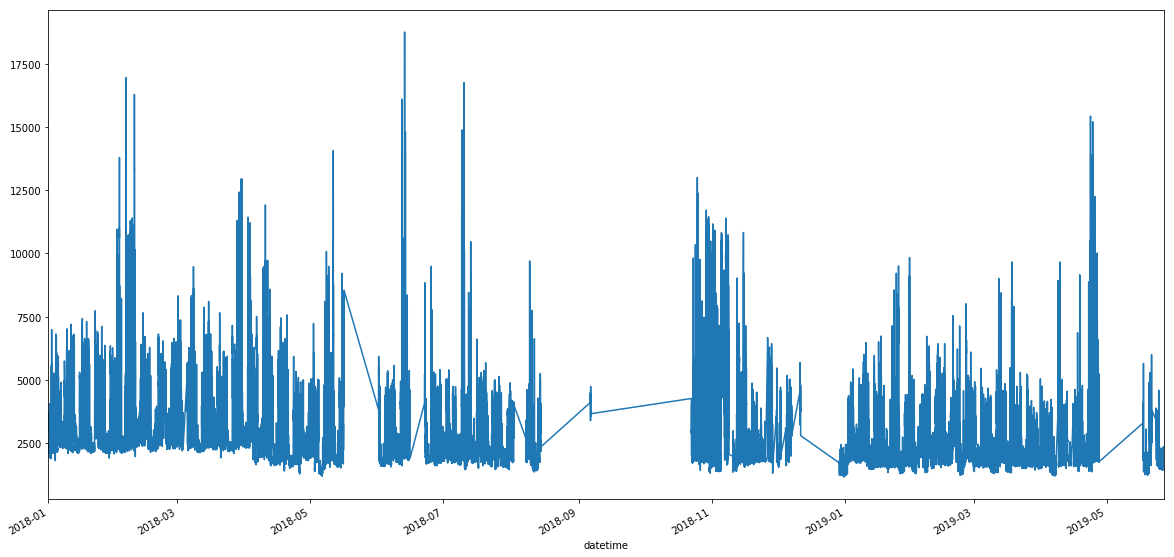

In [3]:
df = df.loc[df.power < 3000000 ]
df.power.plot(figsize=(20,10))

In [4]:
temp_scaler = MinMaxScaler(feature_range=(0,1))
power_scaler = MinMaxScaler(feature_range=(0,1))
df2 = df.dropna()

In [5]:
for col in df2.columns:
    if col.startswith("s"):
        col_df = pd.get_dummies(df2[col], prefix=col)
        df2 = df2.join(col_df)

        # Drop the original column that was expanded
        df2.drop(columns=[col], inplace=True)
    
    if col.startswith("iat") or col == "oat":
        df_normalized = pd.DataFrame(temp_scaler.fit_transform(df2[[col]]), columns=[col], index=df2.index)
        df2[col] = df_normalized[col]
        
    if col == "power":
        df_normalized = pd.DataFrame(power_scaler.fit_transform(df2[[col]]), columns=[col], index=df2.index)
        df2[col] = df_normalized[col]

/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [22]:
df2.head()

,power,oat,iat0,iat1,iat2,iat3,s0_0.0,s0_1.0,s0_2.0,s1_0.0,s1_1.0,s1_2.0,s2_0.0,s2_1.0,s2_2.0,s2_3.0,s3_0.0,s3_1.0,s3_2.0,s3_3.0
datetime,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00-08:00,0.057131,0.293881,0.058824,0.134630,0.304348,0.117647,1,0,0,1,0,0,1,0,0,0,1,0,0,0
2018-01-01 00:10:00-08:00,0.063728,0.292826,0.058824,0.134630,0.304348,0.117647,1,0,0,1,0,0,1,0,0,0,1,0,0,0
2018-01-01 00:20:00-08:00,0.071973,0.274890,0.058824,0.134630,0.304348,0.117647,1,0,0,1,0,0,1,0,0,0,1,0,0,0
2018-01-01 00:30:00-08:00,0.069137,0.292826,0.058824,0.134630,0.304348,0.117647,1,0,0,1,0,0,1,0,0,0,1,0,0,0
2018-01-01 00:40:00-08:00,0.060287,0.294073,0.058824,0.131076,0.304348,0.117647,1,0,0,1,0,0,1,0,0,0,1,0,0,0


In [6]:
split_data = pytz.timezone("US/Pacific").localize(datetime.datetime(year=2019, month=1, day=1, hour=0, minute=0))

X_train = df2.loc[(df2.index < split_data)]
y_train = df2.loc[(df2.index < split_data), 'power']

X_test = df2.loc[(df2.index >= split_data)]
y_test = df2.loc[(df2.index >= split_data), 'power']

In [7]:
# Number of columns in X_train
NUM_FEATURES    = len(X_train.columns)

# A sequence contains NUM_TIMESTEPS number of elements and predicts NUM_PREDICTIONS number of predictions
NUM_TIMESTEPS   = 24*6

# Since this is an iterative method, model will predict only 1 timestep ahead
NUM_MODEL_PREDICTIONS = 1

# 4 hour predictions = Fourty eight 5min predictions
NUM_ACTUAL_PREDICTIONS = 4*6

In [8]:
start_train = pytz.timezone("US/Pacific").localize(datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0))
train_x, train_y = [], []
for i in range(NUM_TIMESTEPS, len(X_train)-NUM_MODEL_PREDICTIONS):
    tx = X_train.loc[start_train+datetime.timedelta(minutes=10*(i-NUM_TIMESTEPS)):start_train+datetime.timedelta(minutes=10*(i-1))].values
    ty = y_train.loc[start_train+datetime.timedelta(minutes=10*(i)):start_train+datetime.timedelta(minutes=10*(i+NUM_MODEL_PREDICTIONS-1))].values
    if len(tx) == NUM_TIMESTEPS and len(ty) == NUM_MODEL_PREDICTIONS:
        train_x.append(tx)
        train_y.append(ty)
train_x, train_y = np.array(train_x), np.array(train_y)
print(train_x.shape)
print(train_y.shape)

start_test = pytz.timezone("US/Pacific").localize(datetime.datetime(year=2019, month=1, day=1, hour=0, minute=0))
test_x, test_y = [], []
test_x_ts, test_y_ts = [], []
for i in range(NUM_TIMESTEPS, len(X_test)-NUM_MODEL_PREDICTIONS):
    tx = X_test.loc[start_test+datetime.timedelta(minutes=10*(i-NUM_TIMESTEPS)):start_test+datetime.timedelta(minutes=10*(i-1))]
    ty = y_test.loc[start_test+datetime.timedelta(minutes=10*(i)):start_test+datetime.timedelta(minutes=10*(i+NUM_MODEL_PREDICTIONS-1))]
    if len(tx) == NUM_TIMESTEPS and len(ty) == NUM_MODEL_PREDICTIONS:
        test_x.append(tx.values)
        test_y.append(ty.values)
        test_x_ts.append(tx.index)
        test_y_ts.append(ty.index)
test_x, test_y = np.array(test_x), np.array(test_y)
test_x_ts, test_y_ts = np.array(test_x_ts), np.array(test_y_ts)
print(test_x.shape)
print(test_y.shape) 

(16271, 144, 20)
(16271, 1)


/anaconda3/envs/mortar/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  exec(code_obj, self.user_global_ns, self.user_ns)
/anaconda3/envs/mortar/lib/python3.6/site-packages/ipykernel/__main__.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


(5474, 144, 20)
(5474, 1)


In [9]:
model = Sequential([
    
    LSTM(units=128, input_shape=(NUM_TIMESTEPS, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=128, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=128, activation='softmax', return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=128, activation='softmax', return_sequences=False),
    Dropout(0.2),
    
    Dense(NUM_MODEL_PREDICTIONS)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 144, 128)          76288     
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 144, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 144, 128)          131584    
_________________________________________________________________
dropout_3 (Dropout)  

In [10]:
# Stop training if validation loss fails to decrease
callbacks = [EarlyStopping(monitor='val_loss', mode='min', verbose=1)]

history = model.fit(train_x, train_y, 
                    epochs=100, batch_size=128, shuffle=False, 
                    validation_data=(test_x, test_y), callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 16271 samples, validate on 5474 samples
Epoch 1/100
16271/16271 [==============================] - 210s 13ms/step - loss: 0.0115 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 2/100
16271/16271 [==============================] - 285s 18ms/step - loss: 0.0080 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Epoch 00002: early stopping


In [11]:
test_y

array([[0.04052611],
       [0.05032504],
       [0.04340403],
       ...,
       [0.07164099],
       [0.06806052],
       [0.062303  ]])

In [12]:
# Make predictions through trained model
pred_y = model.predict(test_x)
pred_y_scaled = power_scaler.inverse_transform(pred_y)
test_y_scaled = power_scaler.inverse_transform(test_y)

In [13]:
mape = []
for i in range(pred_y_scaled.shape[0]):
    mape.append(np.mean(np.abs(pred_y_scaled[i]-test_y_scaled[i])/test_y_scaled[i])*100)
print(np.array(mape).mean())

37.276491181153425


In [14]:
first = True
for i in range(pred_y_scaled.shape[0]):
    if first:
        first = False
        final_df = pd.DataFrame(data={'pred': pred_y_scaled[i], 'true': test_y_scaled[i]}, index=test_y_ts[i])
        continue
    new_df = pd.DataFrame(data={'pred': pred_y_scaled[i], 'true': test_y_scaled[i]}, index=test_y_ts[i])
    final_df.update(new_df)
    final_df = final_df.combine_first(new_df)

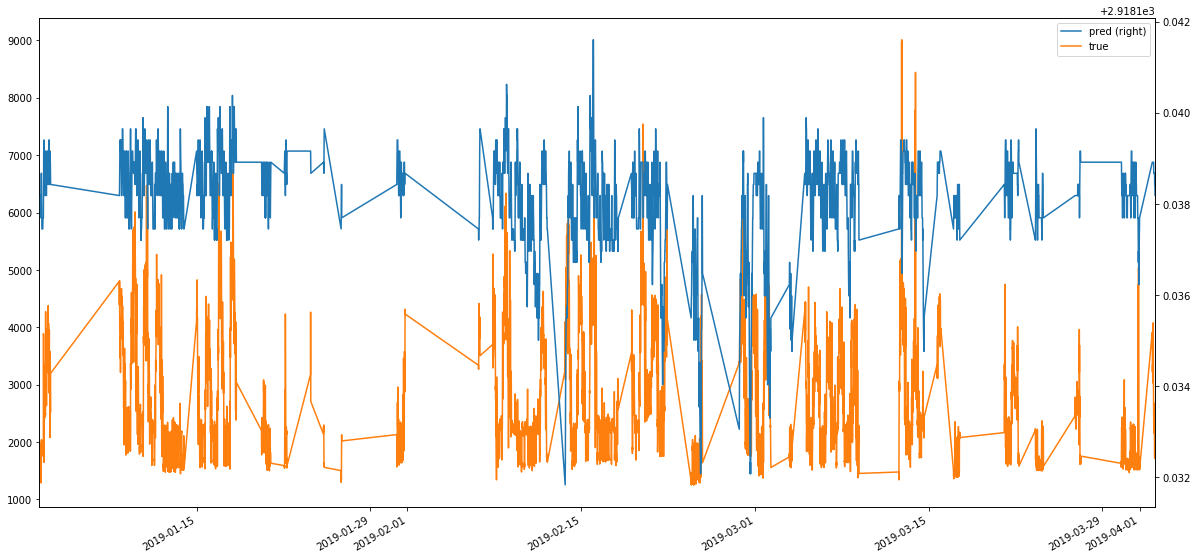

In [19]:
final_df.plot(figsize=(20,10), secondary_y='pred')

In [20]:
final_df.mean()

pred    2918.138078
true    2715.759033
dtype: float64

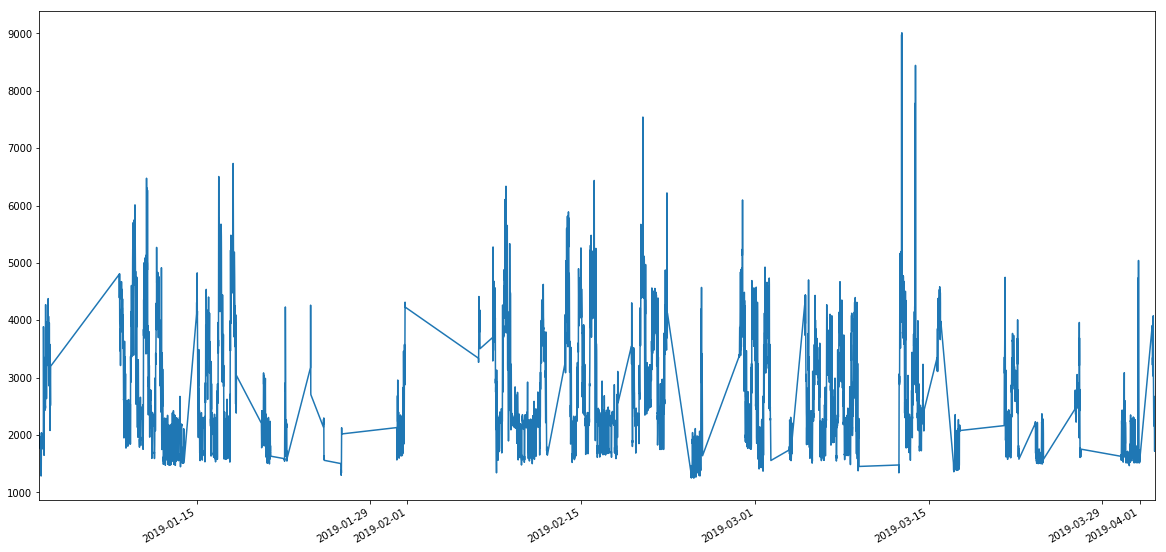

In [18]:
plt.figure(figsize=(20,10))
final_df.true.plot()

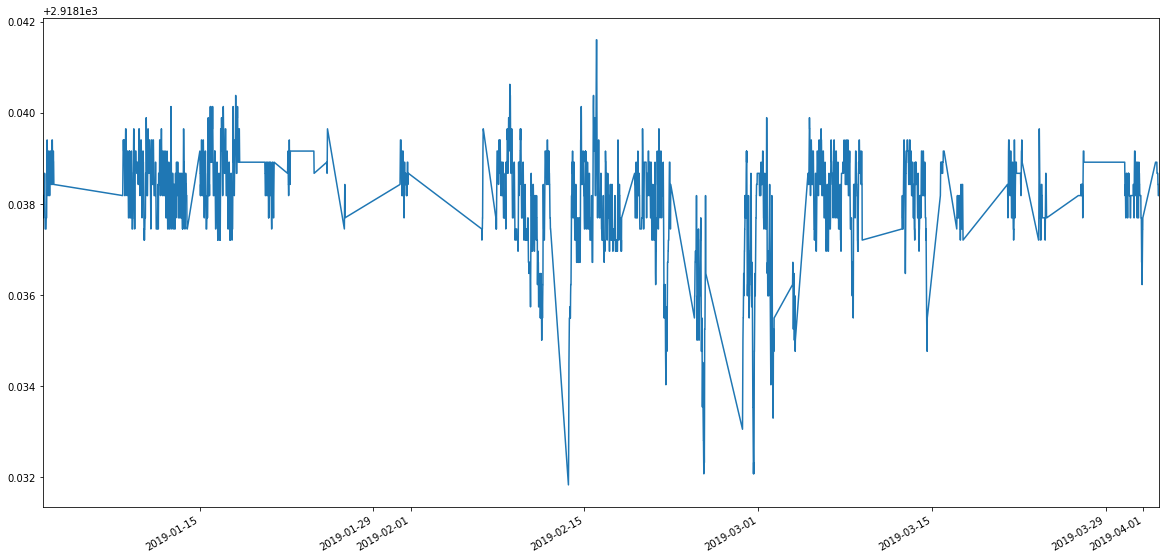

In [16]:
final_df.pred.plot(figsize=(20,10))

In [17]:
final_df.mean()

pred    2918.138078
true    2715.759033
dtype: float64